## Imports - checking GPU

In [3]:
import numpy as np
import pandas as pd
import os
os.environ['HDF5_DISABLE_VERSION_CHECK']='2'
import keras
import cv2

import random
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow.keras.metrics as metric
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D 
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

os.chdir(r"C:\Users\Áron\Desktop\xray")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2946702919030099782
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3138361755
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5828824734115594835
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### Insight 

In [4]:
def how_many(path):
    os.chdir(path)
    res = len([name for name in os.listdir('.') if os.path.isfile(name)])
    os.chdir("..")
    return res

In [5]:
normal = (how_many(r"C:\Users\Áron\Desktop\xray\train\normal") +how_many(r"C:\Users\Áron\Desktop\xray\test\normal") + 
            how_many(r"C:\Users\Áron\Desktop\xray\val\normal"))

pneumonia = (how_many(r"C:\Users\Áron\Desktop\xray\train\opacity") +how_many(r"C:\Users\Áron\Desktop\xray\test\opacity")+ 
            how_many(r"C:\Users\Áron\Desktop\xray\val\opacity"))

In [6]:
print(f"Normal: {normal}, pneumonia cases: {pneumonia}")

Normal: 1583, pneumonia cases: 4273


In [7]:
d = {'Normal cases': [normal], 'Pneumonia cases': [pneumonia]}
df = pd.DataFrame(data = d)

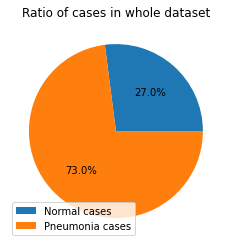

In [8]:
plt.pie(df.unstack(), autopct='%1.1f%%')
plt.legend(["Normal cases", "Pneumonia cases"])
plt.title("Ratio of cases in whole dataset")
plt.show()

In [9]:
def get_ratio(normal_dir, pneumonia_dir, plot_title):
    os.chdir(r"C:\Users\Áron\Desktop\xray")
    normal = how_many(normal_dir)
    pneumonia = how_many(pneumonia_dir)
    
    d = {'Normal cases': [normal], 'Pneumonia cases': [pneumonia]}
    df_train = pd.DataFrame(data = d)
    
    plt.pie(df_train.unstack(), autopct='%1.1f%%')
    plt.legend(["Normal cases", "Pneumonia cases"])
    plt.title(plot_title)
    plt.show()
    print(d)

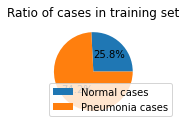

{'Normal cases': [1082], 'Pneumonia cases': [3110]}


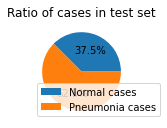

{'Normal cases': [234], 'Pneumonia cases': [390]}


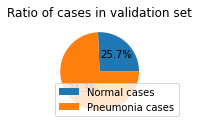

{'Normal cases': [267], 'Pneumonia cases': [773]}


In [10]:
%matplotlib inline
plt.subplot(1, 3, 1)
plt.show(get_ratio(r"C:\Users\Áron\Desktop\xray\train\normal", r"C:\Users\Áron\Desktop\xray\train\opacity", "Ratio of cases in training set"))

plt.subplot(1, 3, 2)
plt.show(get_ratio(r"C:\Users\Áron\Desktop\xray\test\normal", r"C:\Users\Áron\Desktop\xray\test\opacity", "Ratio of cases in test set"))

plt.subplot(1, 3, 3)
plt.show(get_ratio(r"C:\Users\Áron\Desktop\xray\val\normal", r"C:\Users\Áron\Desktop\xray\val\opacity", "Ratio of cases in validation set"))

## Data generator

In [11]:
os.chdir(r"C:\Users\Áron\Desktop\xray")

In [34]:
train_augmentation = ImageDataGenerator(
                                        zoom_range = 0.02,
                                        rescale = 1./255)

val_augmentation = ImageDataGenerator(
                                        rescale = 1./255, 
                                        zoom_range = 0.02)

test_augmentation = ImageDataGenerator(
                                        rescale = 1./255,
                                        zoom_range = 0.02)

train_set = train_augmentation.flow_from_directory(
                                        "train", 
                                        target_size=(500,500), 
                                        color_mode="grayscale", 
                                        class_mode="binary", 
                                        batch_size=32)

val_set = val_augmentation.flow_from_directory(
                                        "val", 
                                        target_size=(500,500), 
                                        color_mode="grayscale", 
                                        class_mode="binary", 
                                        batch_size=32)

test_set = test_augmentation.flow_from_directory(
                                        "test", 
                                        target_size=(500,500), 
                                        color_mode="grayscale", 
                                        class_mode="binary", 
                                        batch_size=32)

Found 4192 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [35]:
imgs, labels = next(train_set)

In [36]:
imgs[0]

array([[[0.08129457],
        [0.0841287 ],
        [0.07884974],
        ...,
        [0.02817596],
        [0.        ],
        [0.        ]],

       [[0.07235928],
        [0.07941996],
        [0.0702779 ],
        ...,
        [0.03110115],
        [0.        ],
        [0.        ]],

       [[0.06793369],
        [0.07312064],
        [0.05867665],
        ...,
        [0.03756249],
        [0.00194806],
        [0.        ]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]], dtype=float32)

In [37]:
for i in range(10):
    cv2.imshow("pictures",imgs[i])
    cv2.waitKey(0)  

    #need to not crash
    cv2.destroyAllWindows() 
cv2.destroyAllWindows() 

## Model

### Values

In [38]:
lr = 0.0001
dropout = 0.4
nodes = 12

In [39]:
#Reproducable results
seed_value= 123

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)


tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [40]:
#Model
model = Sequential([
                    Conv2D(filters=64, kernel_size=(3,3), padding="valid",  input_shape=(500, 500, 1)),
                    Activation("relu"),
                    BatchNormalization(),
                    MaxPooling2D(pool_size=(3,3), padding="valid"),
                    Dropout(rate=dropout),

                    Conv2D(filters=64, kernel_size=(3,3), padding="valid",  input_shape=(500, 500, 1)),
                    Activation("relu"),
                    BatchNormalization(),
                    MaxPooling2D(pool_size=(3,3), padding="valid"),
                    Dropout(rate=dropout),

                    Conv2D(filters=64, kernel_size=(3,3), padding="valid",  input_shape=(500, 500, 1)),
                    Activation("relu"),
                    BatchNormalization(),
                    MaxPooling2D(pool_size=(3,3), padding="valid"),
                    Dropout(rate=dropout),

                    Flatten(),
                    Dense(units=nodes, activation="relu"),
                    Dropout(rate=dropout),
                    Dense(units=1, activation="sigmoid")
])
opt = Adam(learning_rate= lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy", metric.Recall(), metric.Precision()])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 498, 498, 64)      640       
_________________________________________________________________
activation_3 (Activation)    (None, 498, 498, 64)      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 498, 498, 64)      256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 166, 166, 64)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 166, 166, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 164, 164, 64)      36928     
_________________________________________________________________
activation_4 (Activation)    (None, 164, 164, 64)     

In [42]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.0001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

## Tensorboard

In [43]:
%pwd

'C:\\Users\\Áron\\Desktop\\xray'

In [44]:
log_dir = f"logs\lr_{lr},dropout_{dropout}_1"

In [45]:
log_dir

'logs\\lr_0.0001,dropout_0.4_1'

In [46]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Fitting

In [47]:
#Early Stopping
es = EarlyStopping(monitor='val_accuracy', 
    patience=20, 
    min_delta=0.01, 
    verbose = 1,
    restore_best_weights=True)

In [48]:
model.fit(x=train_set, epochs=100, verbose=1, validation_data=val_set, 
              validation_steps=len(val_set), callbacks=[tensorboard_callback, es])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 262 steps, validate for 65 steps
Epoch 1/100
  1/262 [..............................] - ETA: 55:25WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: 


ResourceExhaustedError:  OOM when allocating tensor with shape[16,64,498,498] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node MaxPoolGrad_2 (defined at <ipython-input-48-256394f5991d>:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_5718]

Function call stack:
distributed_function


### Evaluation 

In [ ]:
evaluation = model.evaluate(x=test_set, steps=len(test_set))